In [1]:
import threading
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

from torch.autograd import Variable

from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import math
import random
from urllib.request import urlopen
from tqdm import tqdm
import sys
import os
sys.path.append('taming-transformers')
from omegaconf import OmegaConf
from taming.models import cond_transformer, vqgan
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from torch.cuda import get_device_properties
torch.backends.cudnn.benchmark = False
from torch_optimizer import DiffGrad, AdamP, RAdam
from CLIP import clip
import kornia.augmentation as K
import imageio
from PIL import ImageFile, Image, PngImagePlugin, ImageChops
ImageFile.LOAD_TRUNCATED_IMAGES = True
from subprocess import Popen, PIPE
import re

import sklearn
from sklearn import manifold
import umap

In [2]:
clip.available_models()

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B/32', 'ViT-B/16']

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
model, preprocess = clip.load('ViT-B/32', device)

In [5]:
class Hook:
    """Attaches to a module and records its activations and gradients."""

    def __init__(self, module: nn.Module):
        self.data = None
        self.hook = module.register_forward_hook(self.save_grad)
        
    def save_grad(self, module, input, output):
        self.data = output
        output.requires_grad_(True)
        output.retain_grad()
        
    def __enter__(self):
        return self
    
    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.hook.remove()
        
    @property
    def activation(self) -> torch.Tensor:
        return self.data
    
    @property
    def gradient(self) -> torch.Tensor:
        return self.data.grad

In [6]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [7]:
# assist from https://web.stanford.edu/~nanbhas/blog/forward-hooks-pytorch/
activations = {}
gradients = {}
def getActivation(name):
    # the hook signature 
    def hook(model, input, output):
        
        output.requires_grad_(True)
        output.retain_grad()
        gradients[name] = output.grad
        activations[name] = output.detach()
    return hook

In [8]:
hooks = []
layers = np.concatenate([[model.visual.conv1], model.visual.transformer.resblocks[1::2]])
layernames = np.concatenate([['layer0'], [f'layer{i}' for i in range(1,13,2)]], dtype=str)
for l, n in zip(layers, layernames):
    hooks.append(l.register_forward_hook(getActivation(n)))

In [10]:
image = preprocess(Image.open("data/tyrus.jpg")).unsqueeze(0).to(device)
image_features = model.encode_image(image.cuda())

In [66]:
def process_folder(folder_name):
    
    
    folder_files = os.listdir(folder_name)
    folder_tensors = torch.vstack([preprocess(Image.open(folder_name + folder_file)).unsqueeze(0).to(device) for folder_file in folder_files])
    return folder_tensors

# Collect activations across layers

In [248]:
artist_a = process_folder("data/tyrus/")
artist_b = process_folder("data/rothko/")

In [249]:
image_tensors = torch.vstack([artist_a, artist_b])
text_inputs = ["style of tyrus wong"] * len(artist_a) + ["style of rothko"] * len(artist_b)
text_inputs = [clip.tokenize([text_input]).to(device) for text_input in text_inputs]
text_target = torch.vstack([model.encode_text(text_input).float() for text_input in text_inputs])

In [250]:
def get_layer_gradients_activations(image_tensor, text_tensor):
    all_layer_gradients = {}
    all_layer_activations = {}
    for layer, name in zip(layers, layernames):
        layer_gradients = []
        layer_activations = []
        with Hook(layer) as hook:

            # Do a forward and backward pass.
            output = model.encode_image(image_tensor.unsqueeze(0))
            output.backward(text_tensor.unsqueeze(0))

            grad = hook.gradient.float()
            act = hook.activation.float()
            layer_gradients.append(grad)
            layer_activations.append(act)
        all_layer_gradients[name] = layer_gradients
        all_layer_activations[name] = layer_activations
    return all_layer_gradients, all_layer_activations

In [251]:
zip(image_tensors, text_target)

In [252]:
[print(image_tensor.shape, text_tensor.shape) for image_tensor, text_tensor in  zip(image_tensors, text_target) ]

torch.Size([3, 224, 224]) torch.Size([512])
torch.Size([3, 224, 224]) torch.Size([512])
torch.Size([3, 224, 224]) torch.Size([512])
torch.Size([3, 224, 224]) torch.Size([512])
torch.Size([3, 224, 224]) torch.Size([512])
torch.Size([3, 224, 224]) torch.Size([512])
torch.Size([3, 224, 224]) torch.Size([512])
torch.Size([3, 224, 224]) torch.Size([512])
torch.Size([3, 224, 224]) torch.Size([512])
torch.Size([3, 224, 224]) torch.Size([512])
torch.Size([3, 224, 224]) torch.Size([512])
torch.Size([3, 224, 224]) torch.Size([512])
torch.Size([3, 224, 224]) torch.Size([512])
torch.Size([3, 224, 224]) torch.Size([512])
torch.Size([3, 224, 224]) torch.Size([512])
torch.Size([3, 224, 224]) torch.Size([512])
torch.Size([3, 224, 224]) torch.Size([512])
torch.Size([3, 224, 224]) torch.Size([512])
torch.Size([3, 224, 224]) torch.Size([512])
torch.Size([3, 224, 224]) torch.Size([512])
torch.Size([3, 224, 224]) torch.Size([512])
torch.Size([3, 224, 224]) torch.Size([512])
torch.Size([3, 224, 224]) torch.

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [253]:
def process_batch_gradients_activations(image_tensors, text_target):
    all_gradients_activations = {}
    ids = range(len(image_tensors))
    for image_tensor, text_tensor, file_id in zip(image_tensors, text_target, ids):
        all_gradients_activations[file_id] = get_layer_gradients_activations(image_tensor, text_tensor)
    return all_gradients_activations

In [254]:
batch_gradients_activations = process_batch_gradients_activations(image_tensors, text_target)

In [255]:
layernames

array(['layer0', 'layer1', 'layer3', 'layer5', 'layer7', 'layer9',
       'layer11'], dtype='<U7')

In [256]:
batch_gradients_activations[0][0].keys()

dict_keys(['layer0', 'layer1', 'layer3', 'layer5', 'layer7', 'layer9', 'layer11'])

In [257]:
def extract_gradients_for_layer(batch_gradients_activations, layername):
    
    image_keys = batch_gradients_activations.keys()
    gradients_for_layer = [batch_gradients_activations[image_key][0][layername] for image_key in image_keys]
    return gradients_for_layer

In [258]:
def extract_activations_for_layer(batch_gradients_activations, layername):
    
    image_keys = batch_gradients_activations.keys()
    activations_for_layer = [batch_gradients_activations[image_key][1][layername] for image_key in image_keys]
    return activations_for_layer

In [259]:
import umap

In [260]:
activations_layer0 = extract_activations_for_layer(batch_gradients_activations, layernames[0])
activations_layer1 = extract_activations_for_layer(batch_gradients_activations, layernames[1])
activations_layer3 = extract_activations_for_layer(batch_gradients_activations, layernames[2])
activations_layer5 = extract_activations_for_layer(batch_gradients_activations, layernames[3])
activations_layer7 = extract_activations_for_layer(batch_gradients_activations, layernames[4])
activations_layer9 = extract_activations_for_layer(batch_gradients_activations, layernames[5])
activations_layer11 = extract_activations_for_layer(batch_gradients_activations, layernames[6])

In [261]:
gradients_layer0 = extract_gradients_for_layer(batch_gradients_activations, layernames[0])
gradients_layer1 = extract_gradients_for_layer(batch_gradients_activations, layernames[1])
gradients_layer3 = extract_gradients_for_layer(batch_gradients_activations, layernames[2])
gradients_layer5 = extract_gradients_for_layer(batch_gradients_activations, layernames[3])
gradients_layer7 = extract_gradients_for_layer(batch_gradients_activations, layernames[4])
gradients_layer9 = extract_gradients_for_layer(batch_gradients_activations, layernames[5])
gradients_layer11 = extract_gradients_for_layer(batch_gradients_activations, layernames[6])

In [295]:
gradient = gradients_layer0[2][0]

In [309]:
activations_layer11[2][0].cpu().detach().numpy().shape

(50, 1, 768)

In [310]:
def flatten_activations(activation_for_layer):
    activation_for_layer = [activation[0].cpu().detach().numpy()  for activation in activation_for_layer]
    activation_for_layer = np.vstack([activation.flatten() for activation in activation_for_layer])
    return activation_for_layer

# def flatten_activations(activation_for_layer):
#     activation_for_layer = [activation[0][0].cpu().detach().numpy()  for activation in activation_for_layer]
#     activation_for_layer = np.vstack([activation.flatten() for activation in activation_for_layer])
#     return activation_for_layer

In [311]:
c = ['r'] * len(artist_a) + ['b'] * len(artist_b)

In [312]:
flattened_activations = flatten_activations(activations_layer11)
standard_embedding = umap.UMAP(random_state=42).fit_transform(flattened_activations)
#plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=mnist.target.astype(int), s=0.1, cmap='Spectral');

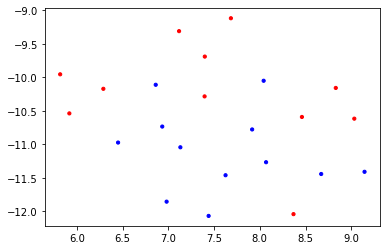

In [313]:
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=c, s=10, cmap='Spectral');

In [314]:
flattened_activations.shape

(23, 38400)

In [315]:
tsne = manifold.TSNE(2)

In [316]:
tsne_embedding = tsne.fit_transform(flattened_activations)

/root/anaconda3/envs/replearn/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/root/anaconda3/envs/replearn/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [317]:
tsne_embedding.shape

(23, 2)

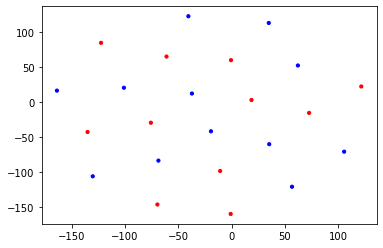

In [318]:
plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], c=c, s=10, cmap='Spectral');

# Last layer

In [319]:
encoded_image_tensors = torch.vstack([model.encode_image(image_tensor.unsqueeze(0)) for image_tensor in image_tensors])

In [320]:
encoded_image_tensors

tensor([[-0.4009, -0.0471,  0.2037,  ...,  0.7637, -0.2610,  0.1206],
        [ 0.3325, -0.1918, -0.2485,  ...,  0.2260, -0.2251,  0.2578],
        [-0.2742,  0.0750,  0.1445,  ...,  0.3491, -0.1890, -0.1177],
        ...,
        [ 0.5503,  0.0839, -0.0478,  ...,  0.5933, -0.1561,  0.2373],
        [ 0.4314, -0.0501,  0.1462,  ..., -0.0473, -0.0171,  0.1033],
        [ 0.4434, -0.2498, -0.0593,  ...,  0.4988,  0.0841, -0.0356]],
       device='cuda:0', dtype=torch.float16, grad_fn=<CatBackward>)

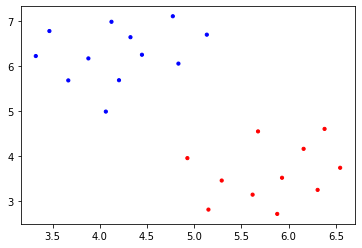

In [331]:
standard_embedding = umap.UMAP(random_state=32).fit_transform(encoded_image_tensors.cpu().detach().numpy())
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=c, s=10, cmap='Spectral');

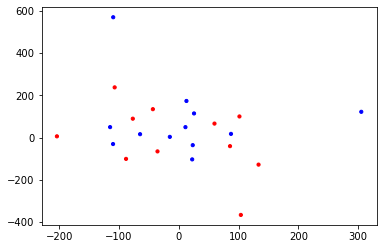

In [332]:
tsne_embedding = tsne.fit_transform(encoded_image_tensors.cpu().detach().numpy())
plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], c=c, s=10, cmap='Spectral');

In [328]:
from generate import vector_quantize
#vector_quantize(z.movedim(1, 3), model.quantize.embed.weight).movedim(3, 1)

usage: ipykernel_launcher.py [-h] [-p PROMPTS] [-ip IMAGE_PROMPTS]
                             [-i MAX_ITERATIONS] [-se DISPLAY_FREQ]
                             [-s SIZE SIZE] [-ii INIT_IMAGE] [-in INIT_NOISE]
                             [-iw INIT_WEIGHT] [-m CLIP_MODEL]
                             [-conf VQGAN_CONFIG] [-ckpt VQGAN_CHECKPOINT]
                             [-nps [NOISE_PROMPT_SEEDS ...]]
                             [-npw [NOISE_PROMPT_WEIGHTS ...]] [-lr STEP_SIZE]
                             [-cutm {original,updated,nrupdated,updatedpooling,latest}]
                             [-cuts CUTN] [-cutp CUT_POW] [-sd SEED]
                             [-opt {Adam,AdamW,Adagrad,Adamax,DiffGrad,AdamP,RAdam,RMSprop}]
                             [-o OUTPUT] [-vid] [-zvid] [-zs ZOOM_START]
                             [-zse ZOOM_FREQUENCY] [-zsc ZOOM_SCALE]
                             [-zsx ZOOM_SHIFT_X] [-zsy ZOOM_SHIFT_Y]
                             [-cpe PROMPT_FREQUE

SystemExit: 2

# Todo: Test effect of describing images better